In [1]:
import os
import numpy as np
import pandas as pd
from ExKMC.Tree import Tree as ExTree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

### Load Data

In [9]:
# Read and process data:
data, data_label_array, feature_labels, scaler = load_preprocessed_mnist()

import math
size = math.ceil(0.1 * len(data))
random_samples = np.sort(np.random.choice(len(data), size = size, replace = False))
data = data[random_samples, :]
data_labels = data_label_array[random_samples]

# Parameters:
n = data.shape[0]
d = data.shape[1]
k = 10

In [33]:
np.min(data)

-1.2778690230072927

In [34]:
np.max(data)

264.5732412773447

In [10]:
np.mean(data, axis = 1)

array([0.13768007, 0.15553721, 0.0972539 , ..., 0.14621349, 0.13285151,
       0.2092487 ])

### KMeans

In [10]:
np.random.seed(342)
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

39.26565081046767

In [5]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(data_label_array, flatten_labels(kmeans_labels))

0.3187404362493331

### IMM

In [12]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_centers = update_centers(data, kmeans.cluster_centers_, exkmc_assignment)
imm_depth = exkmc_tree.depth
kmeans_cost(data, exkmc_centers, exkmc_assignment, average = True, normalize = True)

44.701302126215914

### SVM

In [8]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

cselect = 0
y = (kmeans.labels_ == cselect).astype(int)
svm = LinearSVC()
#svm.fit(data, y)
#svm_labels = svm.predict(data)

selector = RFE(svm, n_features_to_select=2, step=1)
selector = selector.fit(data, y)
selected_features = selector.support_

X_select = data[:, selected_features]
svm.fit(X_select, y)
svm_labels = svm.predict(X_select)

KeyboardInterrupt: 

In [7]:
np.sum(y)

11343

In [6]:
np.sum(y == svm_labels)/n

0.9640571428571428

### Decision Forest

In [13]:
np.random.seed(342)

In [15]:
# Module Parameters:
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
n_sets = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : [2],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : imm_depth
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, imm_depth + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# SVM set:
svm_params = {
    'num_rules' : n_sets,
    'num_features' : 2,
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}



In [16]:
forest = DecisionForest(**forest_params_depth_2)
forest.fit(data, kmeans_labels)

In [17]:
forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

In [7]:
svm_set = SVMSet(**svm_params)
svm_set.fit(data, kmeans_labels)

KeyboardInterrupt: 

### Pruning

In [29]:
model = forest_depth_imm
search_range = np.linspace(0,10,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

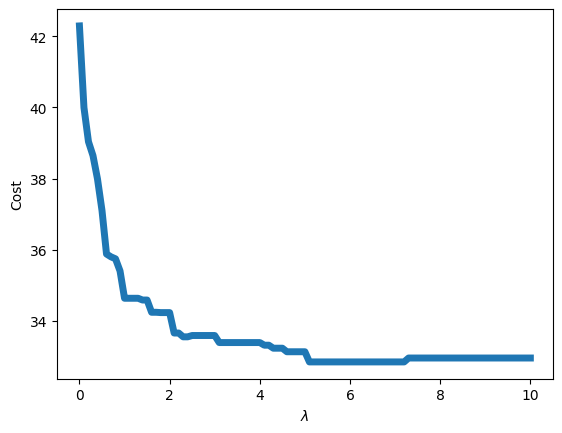

In [30]:
plt.plot(search_range, objective_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

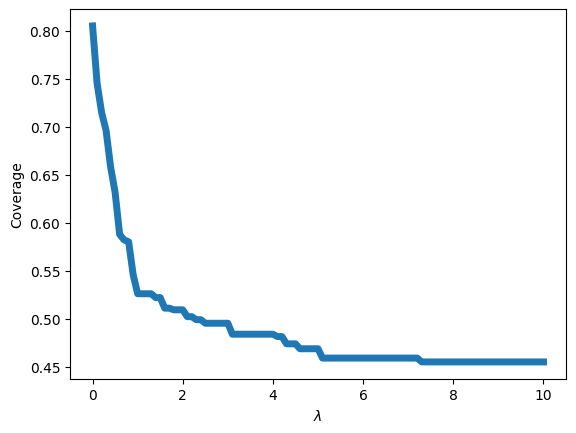

In [31]:
plt.plot(search_range, coverage_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [32]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.75,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,10,101),
    'cpu_count' : 1
}

In [24]:
forest.prune(**prune_params)
forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)

ValueError: Decision set has not been pruned. If prune() was called, this is likely because coverage requirements were not met.

In [33]:
forest_depth_imm.prune(**prune_params)
forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)

In [16]:
120 * 100 / 60 /60

3.3333333333333335